In [21]:
#General Import and Naming

Model_Name = 'ANN_COSMO'
File_Name = 'ANN_Description'
File_Dataset = "Dataset_CMCCPP_Sand8_wdesc.xlsx"
File_Surfactant = 'Surfactant.xlsx'
File_Solid  = 'Solid.xlsx'
attr = ''

seed = 24

# Python â‰¥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn â‰¥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow â‰¥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(seed)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann " + File_Name
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [25]:
#Name Selection
Desc_Config = ['Xeq(mg/L)', 'Temperature_(C)', 'pH_Alkalinity', 'Salinity_Monovalent(%wt)' ]
Desc_Target = ['Sum of Yads(mg/g)']
Desc_Solid =  ['PZC','Size(micro_meter)', 'Area(m^2/g)']

#Load dataset
df = pd.read_excel(File_Dataset)

# Select df range
Dataset_General_CMCCPP = Desc_Config + ['PZC','Area(m^2/g)' ] + ['Transitional', 'Degree_of_Branching', 'Surf_Length' ] + ['R','Critical Micelle Concentration (M)'] + Desc_Target
Dataset_COSMO_CMCCPP = Desc_Config + ['PZC','Area(m^2/g)' ] + ['NHB-HB_Donor'] + ['Head_NHB-Hydrophobicity', 'Head_NHB-HB_Acceptor', 'Head_OT-HB_Acceptor'] + ['Tail_NHB-Hydrophobicity'] + ['R', 'Critical Micelle Concentration (M)'] + Desc_Target
Dataset_COSMO_CMCCPP_LV = Desc_Config + ['PZC','Area(m^2/g)' ] + ['NHB-HB_Donor'] + ['Head_NHB-Hydrophobicity', 'Head_NHB-HB_Acceptor', 'Head_OT-HB_Acceptor'] + ['Tail_NHB-Hydrophobicity'] + ['MolVol','Length (Avogadro, A)','Critical Micelle Concentration (M)']+ Desc_Target
Dataset_COSMO = Desc_Config + ['PZC','Area(m^2/g)' ] + ['NHB-HB_Donor'] + ['Head_NHB-Hydrophobicity', 'Head_NHB-HB_Acceptor', 'Head_OT-HB_Acceptor'] + ['Tail_NHB-Hydrophobicity'] + Desc_Target
Dataset_COSMO_LV = Desc_Config + ['PZC','Area(m^2/g)' ] + ['NHB-HB_Donor'] + ['Head_NHB-Hydrophobicity', 'Head_NHB-HB_Acceptor', 'Head_OT-HB_Acceptor'] + ['Tail_NHB-Hydrophobicity'] + ['MolVol','Length (Avogadro, A)']+ Desc_Target

df = df[Dataset_COSMO_LV]
Descriptor_NonX = list(df.columns.values)
Descriptor_NonX.remove('Sum of Yads(mg/g)')
Descriptor_NonX.remove('Xeq(mg/L)' )


#Split Dataset

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.20, random_state=seed)

test_set.head()
train_set.head()

X_test_X = test_set[['Xeq(mg/L)']].copy()
X_test_NonX = test_set[Descriptor_NonX].copy() 
X_test = pd.concat([X_test_X, X_test_NonX], axis=1).copy()
y_test = test_set[['Sum of Yads(mg/g)']].copy()

X_train_X = train_set[['Xeq(mg/L)']].copy()
X_train_NonX = train_set[Descriptor_NonX].copy() 
X_train = pd.concat([X_train_X, X_train_NonX], axis=1).copy()
y_train = train_set[['Sum of Yads(mg/g)']].copy()

In [26]:
#Subclass API Langmuir Layer

class LangmuirLayer(tf.keras.layers.Layer):
    def __init__(self, k, name=None, **kwargs):
        super(LangmuirLayer, self).__init__(name=name)
        self.k = k
        super(LangmuirLayer, self).__init__(**kwargs)
  # def build (self, inputs): no need as no constant introduced
    def get_config(self):
        config = super(LangmuirLayer, self).get_config()
        config.update({"k": self.k})
        return config
    def call(self, inputs):
        self.Ce = inputs[:, 0]
        self.Kl = inputs[:, 1]
        self.qm  = inputs[:, 2]        
        self.qm_mult_kl = tf.math.multiply(self.qm, self.Kl)
        self.kl_mult_ce = tf.math.multiply(self.Kl, self.Ce)
        self.below = tf.math.add(1.0, self.kl_mult_ce)
        self.right = tf.math.divide(self.Ce, self.below)
        self.qe = tf.math.multiply(self.qm_mult_kl, self.right)
        return tf.transpose(self.qe)

train RSME load:0.33549311132847626
test RSME load:0.25737693914734844
Train Rsquare load:0.8954478491060308
Test RSquare load:0.9650532303095803
Saving figure Check Train Scatter #ANN_Description


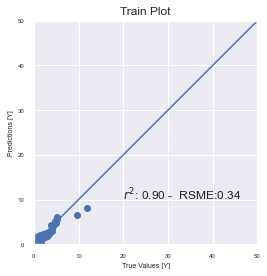

Saving figure Check Test Scatter #ANN_Description


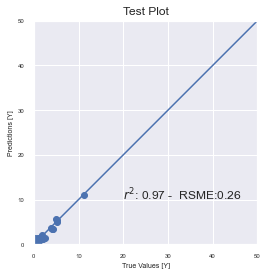

In [27]:
#Load Model ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
tf.keras.backend.clear_session()
tf.random.set_seed(seed)


#Load Model
#File_Name = {fill if different}
model = tf.keras.models.load_model(Model_Name, custom_objects={'LangmuirLayer': LangmuirLayer})


#RSME
from sklearn.metrics import mean_squared_error
pred_train = model.predict([X_train_X, X_train_NonX])
train_RSME = np.sqrt(mean_squared_error(y_train,pred_train))
print('train RSME load:{0}'  .format(train_RSME))
pred = model.predict([X_test_X, X_test_NonX])
test_RSME = np.sqrt(mean_squared_error(y_test,pred))
print('test RSME load:{0}'.format(test_RSME))

#Rsquare
from sklearn.metrics import r2_score
Train_Rsquare = r2_score(y_train, pred_train)
print ('Train Rsquare load:{0}'.format(Train_Rsquare))
Test_RSquare = r2_score(y_test, pred)
print ('Test RSquare load:{0}'.format(Test_RSquare))

#Plot Train 
a = plt.axes(aspect='equal')
plt.scatter(y_train, pred_train)
plt.xlabel('True Values [Y]')
plt.ylabel('Predictions [Y]')
plt.title('Train Plot')
plt.text(20,10, '$r^2$: {0:1.2f} -  RSME:{1:1.2f}'.format(Train_Rsquare, train_RSME) )
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
save_fig('Check Train Scatter'+' #' +File_Name + attr)
plt.show()

#Plot Test
a = plt.axes(aspect='equal')
plt.scatter(y_test, pred)
plt.xlabel('True Values [Y]')
plt.ylabel('Predictions [Y]')
plt.title('Test Plot')
plt.text(20,10, '$r^2$: {0:1.2f} -  RSME:{1:1.2f}'.format(Test_RSquare, test_RSME) )
lims = [0,50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
save_fig('Check Test Scatter'+' #' +File_Name + attr)
plt.show()


In [28]:
# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)

#Beautiful Figure
df_test = pd.read_excel(File_Dataset)
import seaborn as sns; sns.set_theme(color_codes=True)

X_Dataset_X = df_test[['Xeq(mg/L)']].copy()
X_Dataset_NonX = df_test[Descriptor_NonX].copy() 
X_Dataset = pd.concat([X_Dataset_X, X_Dataset_NonX], axis=1).copy()
y_Dataset = df_test[['Sum of Yads(mg/g)']].copy()

#RSME
from sklearn.metrics import mean_squared_error
pred_Dataset = model.predict([X_Dataset_X, X_Dataset_NonX])
Dataset_RSME = np.sqrt(mean_squared_error(y_Dataset,pred_Dataset))
print('Dataset RSME load:{0}'  .format(Dataset_RSME))

#Rsquare
from sklearn.metrics import r2_score
Dataset_Rsquare = r2_score(y_Dataset, pred_Dataset)
print ('Dataset Rsquare load:{0}'.format(Dataset_Rsquare))

#Combine Back
df_test['y_pred'] = pred_Dataset.tolist()

pred_error = np.abs(np.asarray(df_test['Sum of Yads(mg/g)'])-np.asarray(df_test['y_pred']))
df_test['abs_error'] = pred_error.tolist()


Dataset RSME load:0.321287782899626
Dataset Rsquare load:0.9174045994185979


Saving figure Evaluate Scatter (AnionicNonionic) #ANN_Description


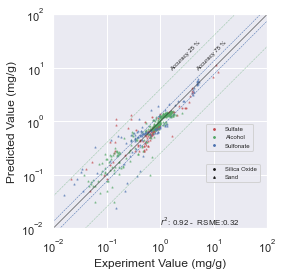

In [75]:
#Surfactant (Anionic Nonionic) & Solid
#Plot Train 
minlim = 0.01
maxlim = 100

a = plt.axes(aspect='equal')
    
plt.xlabel('Experiment Value (mg/g)')
plt.ylabel('Predicted Value (mg/g)')
plt.text(1,minlim*1.1, '$r^2$: {0:1.2f} -  RSME:{1:1.2f}'.format(Dataset_Rsquare, Dataset_RSME), fontsize = 8 )

err = 0.75
lims = [minlim, maxlim]
plt.xlim(lims)
plt.ylim(lims)

# Diagonal 1st
plt.plot(lims,    lims,    'k-', linewidth=0.5)
plt.plot([ minlim*err, maxlim*err],    [ minlim,    maxlim], 'b--', linewidth=0.5)
plt.plot([minlim,    maxlim], [minlim*err, maxlim*err],    'b--', linewidth=0.5)
plt.text(maxlim*err*0.06, maxlim*0.09, 'Accuracy {0:1.0f} % '.format(err*100), fontsize = 6, rotation=45 )

err = 0.25
lims = [minlim, maxlim]
plt.xlim(lims)
plt.ylim(lims)

# Diagonal 2nd
plt.plot([ minlim*err, maxlim*err],    [ minlim,    maxlim], 'g-.', linewidth=0.3)
plt.plot([minlim,    maxlim], [minlim*err, maxlim*err],    'g-.', linewidth=0.3)
plt.text(maxlim*err*0.06, maxlim*0.09, 'Accuracy {0:1.0f} % '.format(err*100), fontsize = 6, rotation=45 )

Solid_List = {'Silica Oxide':'o', 'Sand':'^'}
Surfactant_List = {'Sulfate': 'r', 'Alcohol':'g' , 'Sulfonate': 'b'}

for Solid in Solid_List:
    for Surfactant in Surfactant_List:
        data = df_test[(df_test["Solid_Class"] == Solid) & (df_test["Head_Type"] == Surfactant)]
        scatter = plt.scatter(
            'Sum of Yads(mg/g)', 'y_pred', s=1.5, marker= Solid_List[Solid], 
            color=Surfactant_List[Surfactant],  alpha=0.6, data=data)

# The following two lines generate custom fake lines that will be used as legend entries:
markers1 = [plt.Line2D([0.1,0.1],[0.1,0.1],color=color, marker='o', linestyle='') for color in Surfactant_List.values()]
legend1 = plt.legend(markers1, Surfactant_List.keys(), numpoints=1, loc='upper left', bbox_to_anchor=(0.7, 0.5), fontsize=6, markerscale=0.3)     

markers2 = [plt.Line2D([0.1,0.1],[0.1,0.1],color='k', marker=marker, linestyle='') for marker in Solid_List.values()]
legend2 = plt.legend(markers2, Solid_List.keys(), numpoints=1, loc='lower left', bbox_to_anchor=(0.7, 0.2), fontsize=6, markerscale=0.3)     
plt.gca().add_artist(legend1)

plt.xscale('log')
plt.yscale('log')
save_fig('Evaluate Scatter (AnionicNonionic)'+' #' +File_Name + attr, resolution=1000)
plt.show()

Saving figure Evaluate Ads Eq Conc  #ANN_Description


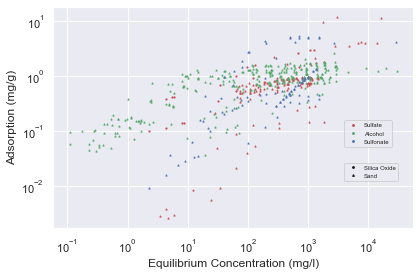

In [76]:
#Surfactant & Solid & Ads Xeql
#Plot Train 

plt.xlabel('Equilibrium Concentration (mg/l)')
plt.ylabel('Adsorption (mg/g)')

Solid_List = {'Silica Oxide':'o', 'Sand':'^'}
Surfactant_List = {'Sulfate': 'r', 'Alcohol':'g' , 'Sulfonate': 'b'}

jitter_ar = np.random.normal(0,0.001,len(df_test.index))
df_test['jitter_ar'] = jitter_ar.tolist()+df_test['Xeq(mg/L)']


for Solid in Solid_List:
    for Surfactant in Surfactant_List:
        data = df_test[(df_test["Solid_Class"] == Solid) & (df_test["Head_Type"] == Surfactant)]
        scatter = plt.scatter(
            'jitter_ar', 'Sum of Yads(mg/g)', s=1.5, marker= Solid_List[Solid], 
            color=Surfactant_List[Surfactant],  alpha=0.9, data=data)

# The following two lines generate custom fake lines that will be used as legend entries:
markers1 = [plt.Line2D([0.1,0.1],[0.1,0.1],color=color, marker='o', linestyle='') for color in Surfactant_List.values()]
legend1 = plt.legend(markers1, Surfactant_List.keys(), numpoints=1, loc='upper left', bbox_to_anchor=(0.8, 0.5), fontsize=6, markerscale=0.3)     

markers2 = [plt.Line2D([0.1,0.1],[0.1,0.1],color='k', marker=marker, linestyle='') for marker in Solid_List.values()]
legend2 = plt.legend(markers2, Solid_List.keys(), numpoints=1, loc='lower left', bbox_to_anchor=(0.8, 0.2), fontsize=6, markerscale=0.3)     
plt.gca().add_artist(legend1)

plt.xscale('log')
plt.yscale('log')
save_fig('Evaluate Ads Eq Conc '+' #' +File_Name + attr, resolution=1000)
plt.show()